## NYC TLC Taxi Trip Data

Data is primarily from:
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Data source: [NYC TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), 
via [NYC Open Data](https://opendata.cityofnewyork.us/).  
© City of New York. Data made available under the NYC Open Data Terms of Use.



In [2]:
import pyarrow.parquet as pq
import pandas as pd

# Load parquet data
trips = pq.read_table('../data/raw/yellow_tripdata_2025-01.parquet')

# Convert to pandas DataFrame
df = trips.to_pandas()

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [4]:
# Load taxi_zone_lookup.csv
taxi_zone_lookup = pd.read_csv("../data/raw/taxi_zone_lookup.csv")

In [5]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [9]:
# Read .shp file
taxi_zones_shape = gpd.read_file("../data/raw/taxi_zones.shp")

In [10]:
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


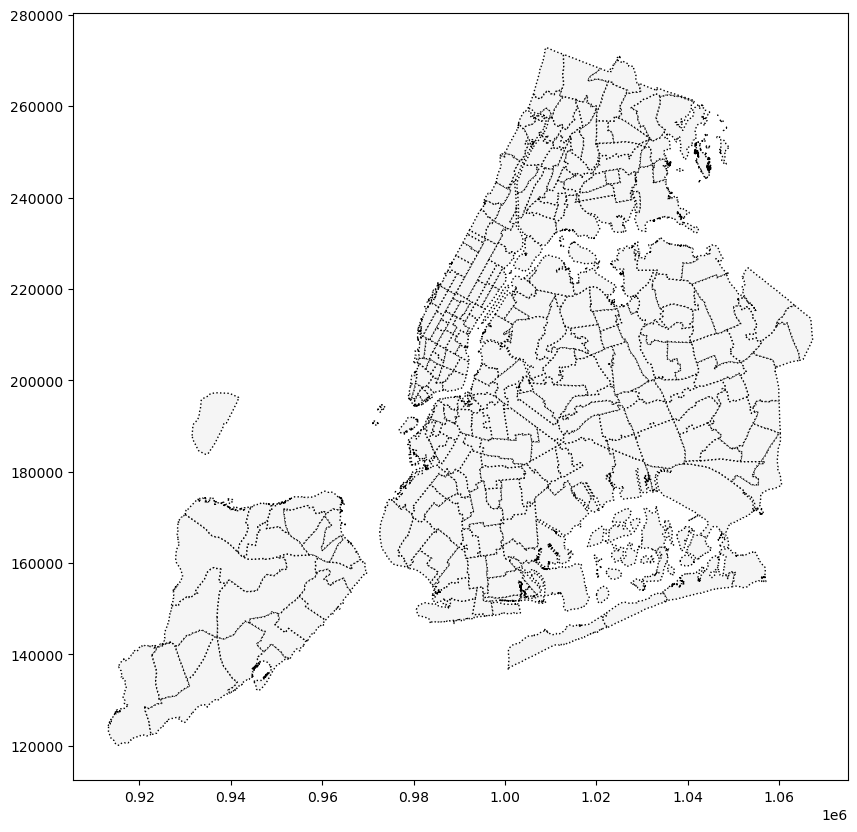

In [11]:
taxi_zones_shape.plot(figsize = (10,10), color = "whitesmoke", linestyle = ":", edgecolor = "black")
plt.show()

In [12]:
import folium

In [13]:
# Reproject to EPSG 4326 for folium
taxi_zones_folium = taxi_zones_shape.to_crs(epsg = 4326)

# Make base map centered on NYC
m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)

# Add polygons
folium.GeoJson(
    taxi_zones_folium,
    tooltip = folium.GeoJsonTooltip(fields = ["zone", "borough"])
).add_to(m)
m.save("../reports/maps/taxi_zones.html")

We seek to create two choropleths counting the both the number of pick up and drop off trips by zone

In [14]:
# Function to make a choropleth that counts the trips in each taxi zone, displaying a tooltip with: Zone, Borough, Trips, Service Zone, LocationID
def make_choropleth(count_col, geo_data, zone_lookup):
    
    # Count trips in each zone
    trips_count = df[count_col].value_counts().reset_index()
    trips_count.columns = ["LocationID", "trips"]

    # Merge this into the orignal GeoPandasDataFrame so that we can use the trips count in the tooltip
    zones =  geo_data.merge(
        trips_count,
        left_on = "LocationID",
        right_on = "LocationID",
        how = "left"
    )

    # Fill missing trip counts with 0 
    zones["trips"] = zones["trips"].fillna(0)

    # We would also like to see the taxi service zone on the tooltip: Yellow, Green etc
    # To do this we will merge the taxi_zone_lookup onto zones as well
    service_zones = zone_lookup[["LocationID", "service_zone"]]

    zones = zones.merge(
        service_zones,
        left_on = "LocationID", 
        right_on = "LocationID",
        how = "left"
    )

    # Fill missing zones with "NA"
    zones["service_zone"] = zones["service_zone"].fillna("NA")

    # Create a base map
    m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)

    # Add a choropleth map to base map
    ch = folium.Choropleth(
        geo_data = zones,
        data = trips_count,
        columns = ["LocationID", "trips"],
        key_on = "feature.properties.LocationID",
        fill_color = "YlGnBu",
        legend_name = count_col + " counts by zone"
        ).add_to(m)

    # Add hover tooltip to the choropleth's polygons
    folium.features.GeoJsonTooltip(
        fields = ["zone", "borough", "trips", "service_zone", "LocationID"],
        aliases = ["Zone:", "Borough:", "Trips:", "Service Zone:", "Location ID:"],
        sticky = False
    ).add_to(ch.geojson)

    # Return map
    return m

In [15]:
# Create pick up Choropleth
m_1 = make_choropleth("PULocationID", taxi_zones_folium, taxi_zone_lookup)

# Export to HTML file
m_1.save("../reports/maps/PULocationID_count_by_zone.html")

# Create drop off Choropleth
m_2 = make_choropleth("DOLocationID", taxi_zones_folium, taxi_zone_lookup)

# Export to HTML file
m_2.save("../reports/maps/DOLocationID_count_by_zone.html")